In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [2]:
url = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
df = pd.read_csv(url, header=None)
raw = df.values
data = raw[:, :-1]   # signals
labels = raw[:, -1]  # 1=normal, 0=abnormal :contentReference[oaicite:3]{index=3}

data = (data - data.min())/(data.max() - data.min())


In [3]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [5]:
X_train_norm = X_train[y_train==1]
X_test_norm = X_test[y_test==1]
X_test_abn = X_test[y_test==0]

input_dim = X_train_norm.shape[1]

In [6]:
inp = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(inp)
x = layers.Dense(32, activation='relu')(x)
latent = layers.Dense(16, activation='relu')(x)


In [7]:
x = layers.Dense(32, activation='relu')(latent)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(input_dim, activation='sigmoid')(x)


In [8]:
autoencoder = models.Model(inputs=inp, outputs=out)


In [9]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [10]:
history = autoencoder.fit(
    X_train_norm, X_train_norm,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    verbose=2
)


Epoch 1/30
33/33 - 4s - 108ms/step - loss: 0.0043 - mae: 0.0416 - val_loss: 0.0029 - val_mae: 0.0326
Epoch 2/30
33/33 - 0s - 7ms/step - loss: 0.0018 - mae: 0.0254 - val_loss: 0.0012 - val_mae: 0.0210
Epoch 3/30
33/33 - 0s - 7ms/step - loss: 0.0010 - mae: 0.0199 - val_loss: 9.8878e-04 - val_mae: 0.0195
Epoch 4/30
33/33 - 0s - 7ms/step - loss: 9.6788e-04 - mae: 0.0193 - val_loss: 9.6466e-04 - val_mae: 0.0192
Epoch 5/30
33/33 - 0s - 7ms/step - loss: 9.3935e-04 - mae: 0.0190 - val_loss: 9.1658e-04 - val_mae: 0.0187
Epoch 6/30
33/33 - 0s - 6ms/step - loss: 8.7524e-04 - mae: 0.0182 - val_loss: 8.2839e-04 - val_mae: 0.0178
Epoch 7/30
33/33 - 0s - 7ms/step - loss: 7.8058e-04 - mae: 0.0172 - val_loss: 7.1967e-04 - val_mae: 0.0165
Epoch 8/30
33/33 - 0s - 8ms/step - loss: 6.9436e-04 - mae: 0.0164 - val_loss: 6.5055e-04 - val_mae: 0.0157
Epoch 9/30
33/33 - 0s - 7ms/step - loss: 6.3333e-04 - mae: 0.0157 - val_loss: 6.1124e-04 - val_mae: 0.0153
Epoch 10/30
33/33 - 0s - 7ms/step - loss: 5.9385e-04 - 

In [11]:
recon_train = autoencoder.predict(X_train_norm)
mse_train = np.mean(np.power(X_train_norm - recon_train, 2), axis=1)
threshold = np.percentile(mse_train, 95)

recon_test = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - recon_test, 2), axis=1)
y_pred = (mse_test > threshold).astype(int)  # 1 indicates anomaly


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [12]:
reconstructions_norm = autoencoder.predict(X_test_norm)
reconstructions_abn  = autoencoder.predict(X_test_abn)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [13]:
mse_norm = np.mean(np.power(X_test_norm - reconstructions_norm, 2), axis=1)
mse_abn  = np.mean(np.power(X_test_abn - reconstructions_abn, 2), axis=1)


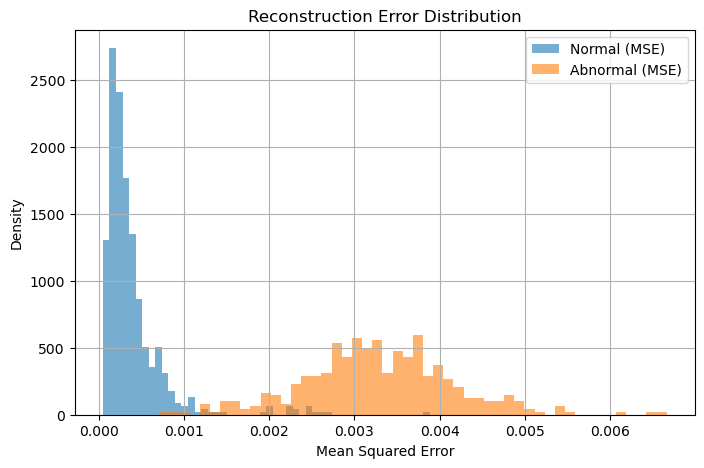

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(mse_norm, bins=50, alpha=0.6, label='Normal (MSE)', density=True)
plt.hist(mse_abn, bins=50, alpha=0.6, label='Abnormal (MSE)', density=True)

plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

<Axes: >

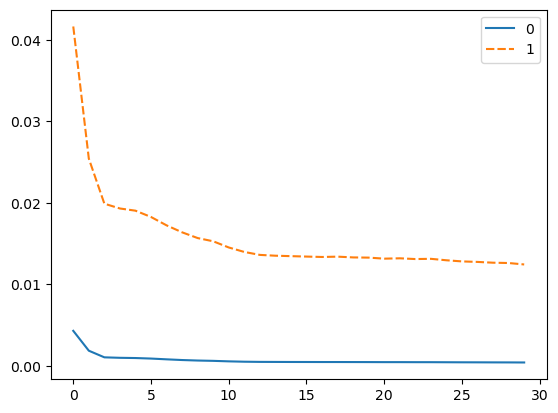

In [15]:
import seaborn as sns
sns.lineplot((history.history['loss'], history.history['mae']))

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
print("Threshold:", threshold)
print(confusion_matrix(y_test.astype(int)==0, y_pred))  # abnormal vs predicted
print(classification_report(y_test.astype(int)==0, y_pred))

Threshold: 0.0010097733510391364
[[562  29]
 [  3 406]]
              precision    recall  f1-score   support

       False       0.99      0.95      0.97       591
        True       0.93      0.99      0.96       409

    accuracy                           0.97      1000
   macro avg       0.96      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



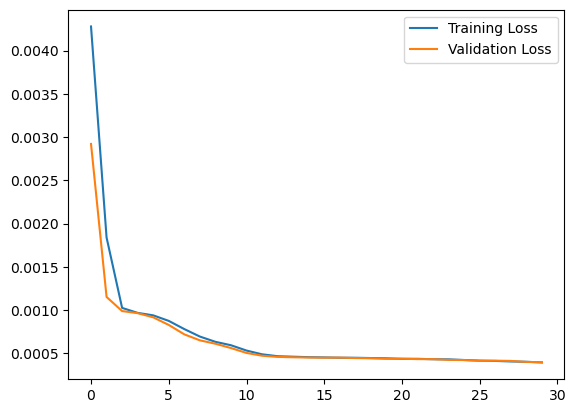

In [17]:

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()